In [1]:
# basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# spacy
import spacy

import re

from sklearn.model_selection import train_test_split

# bag of words and feature selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2

# unsequential models
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# sequence vectorization
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from tensorflow.python.keras.layers import Embedding

# neural network
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LSTM


# evaluation
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 2. Exploratory Data Analysis

### 2.1 Overview 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The train dataset contains 7613 samples with five columns. We will analyze the five columns one by one. 

First, the id column is simply a sequential index of the samples and will not be considered for modelling or prediction.

In [6]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [7]:
len(train['keyword'].unique()), train['keyword'].isna().sum()

(222, 61)

In [8]:
train[train['keyword']=='hijack'].groupby('target').count()['id']

target
0    17
1    16
Name: id, dtype: int64

Second, the keyword column has 222 unique values for the 7613 samples and 61 nan values. Taking the value of 'hijack' as an example and digging into the samples, we find this intuitively negative word is not necessarily related to a disaster. Plus, the words are extracted from the text column.Therefore, we will not consider this column.

In [9]:
len(train['location'].unique()), train['location'].isna().sum()

(3342, 2533)

Third, the location column has 3342 unique values and 2533 nan values. This column may have no valuable information for the analysis.

### 2.2 Text Statistics 

Based on the above analysis, we will focus on the text column and the target column.

In [10]:
train_texts = train['text']

In [11]:
test_texts = test['text']

- Number of words per tweet:

In [12]:
def number_of_words(train):
    # Seperate disaster and non-disaster tweets
    disaster = train[train['target'] == 1]['text']
    non_disaster = train[train['target'] == 0]['text']
    
    # create a plt instance
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    x_disaster = [len(text.split()) for text in disaster]
    ax[0].hist(x_disaster, bins=20)
    ax[0].set_xlabel('Number of words')
    ax[0].set_ylabel('Number of tweets')
    ax[0].set_title('Word counts distribution among disaster tweets')
    
    x_non_disaster = [len(text.split()) for text in non_disaster]
    ax[1].hist(x_non_disaster, bins=20)
    ax[1].set_xlabel('Number of words')
    ax[1].set_ylabel('Number of tweets')
    ax[1].set_title('Word counts distribution among non_disaster tweets')

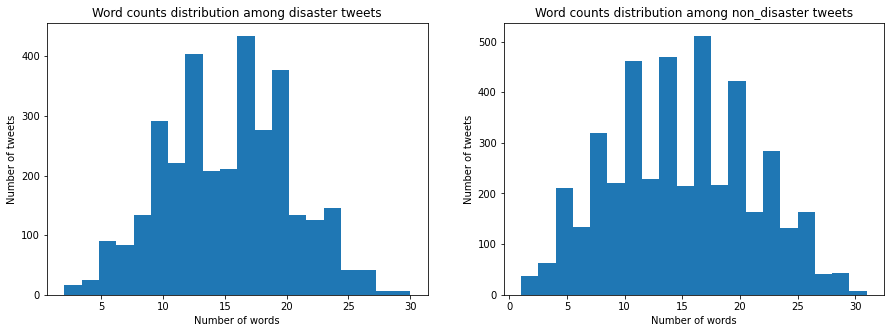

In [13]:
number_of_words(train)

In terms of number of words per tweet, there seems no siginificant difference between disaster and non-disaster tweets.

- Most frequently occurring words

In [14]:
def frequency_of_words(data, top_n):
    
    # Use CountVector to calculate the frequencies of words
    count_vectorizer = CountVectorizer() # count by words on default parameters
    # Fit the vectorizer with all texts and get the vocabulary
    count_vectorizer.fit(data['text'])
    vocabulary = count_vectorizer.get_feature_names()
    
    # Seperate disaster and non-disaster tweets
    disaster = train[train['target'] == 1]['text']
    non_disaster = train[train['target'] == 0]['text']
    
    # Vectorize disaster and non-disaster tweets and calculate the frequencies of each word
    vectorized_disaster = count_vectorizer.transform(disaster)
    word_frequency_disaster = vectorized_disaster.sum(axis=0).tolist()[0]
    
    vectorized_non_disaster = count_vectorizer.transform(non_disaster)
    word_frequency_non_disaster = vectorized_non_disaster.sum(axis=0).tolist()[0]
    
    
    # Store the frequencies into a dataframe
    df = pd.DataFrame({'words': vocabulary, 
                       'frequency_disaster': word_frequency_disaster, 
                       'frequency_non_disaster':word_frequency_non_disaster}) 
    
    # Plot the top_n most frequently occurring words
    df.sort_values(by='frequency_disaster', ascending=False)[:top_n].plot.bar(
        x='words', y='frequency_disaster', figsize=(12,5))
    df.sort_values(by='frequency_non_disaster', ascending=False)[:top_n].plot.bar(
        x='words', y='frequency_non_disaster', figsize=(12,5))

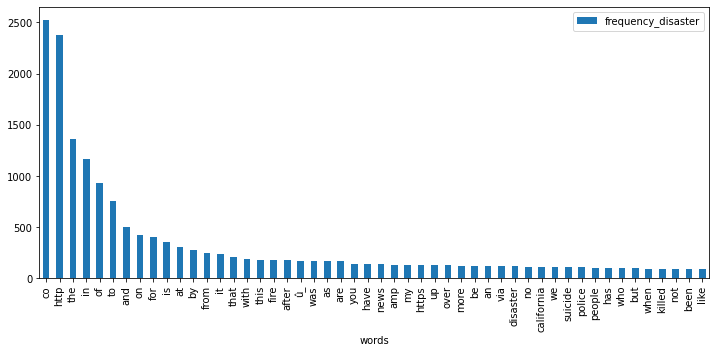

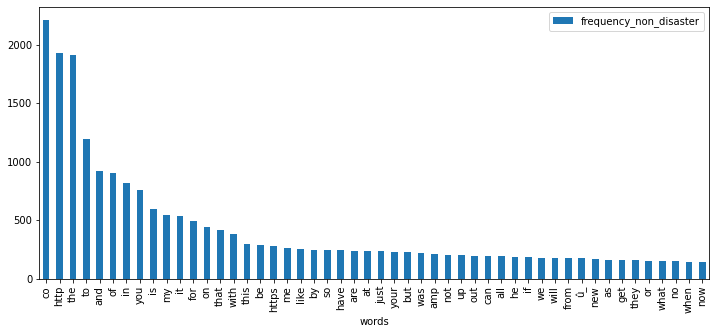

In [15]:
frequency_of_words(train, 50)

Disaster tweets and non-disaster tweets share some of the most frequent words, and many of them are quite neutral in meaning, like co, http, to and in, which gives us a clue for the following text processing.  

### 2.3 Target Statistics

In [16]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

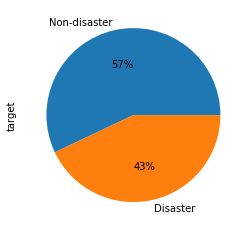

In [17]:
train['target'].value_counts().plot.pie(labels= ['Non-disaster', 'Disaster'], autopct='%.0f%%')

Among the train tweets, 43% indicate a disaster, while 57% do not. It is a basically balanced dataset.

## 2. Data Preprocessing 

We need to convert texts to numbers before feeding them to machine learning models.

Two steps are involved: text processing, tokenization and vectorization.

- Processing: convert a text to neat formats and remove distracting elements from it.

- Tokenization: covert a text to a list of words or subtexts.

- Vectorization: covert a list of words or subtexts to a vector of numbers 

Before tokenizing texts, we need to decide whether or not to keep the order of the words in a text, and the subsequent machine learning models will also be different. 

According to the experiments run by Google https://developers.google.com/machine-learning/guides/text-classification, a threshold of 1500 for the number of samples to number of words per sample ratio can be used to decide data preparating techniques. If the ratio is less than 1500, the order of words can be ignored; otherwise, the order of words should be considered.

In this case, the number of sample is 7613, and the ratio is less than 1500 either according to the raw texts or processed texts. Though, we will also factor in the order of words, and our results are consistent with the conclusion of Google.

### 2.1 Text Processing 

We first remove urls and punctuations from the text using regular expressions, then covert the common abbreviations into regular words, and last use SpaCy to exclude stop words and lemmatize the texts.

In [18]:
# reference: https://www.kaggle.com/code/rftexas/text-only-bert-keras?scriptVersionId=31186559
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "hwy" : "highway",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [19]:
nlp = spacy.load("en_core_web_sm")

In [20]:
def text_processing(text):
    # remove urls
    text = re.sub(r'https?://\S+|www\.\S+', "", text)
    
    # remove punctuations
    text = re.sub(r'[^\w\s]','',text)
    
    # convert abbreviation
    words = text.lower().split()
    for i in range(len(words)):
        word = words[i]
        if word in abbreviations.keys():
            words[i] = abbreviations[word]
    # print(words)
    text = ' '.join(words)
    # remove punctuations, stop words and lemmatize texts using spacy    
    docs = nlp(text)
    words = [token.lemma_.lower() for token in docs if not token.is_stop] # a list of words in sequence
    return ' '.join(words)

In [21]:
train['processed_text'] = train['text'].apply(text_processing)

In [22]:
train.head()

,id,keyword,location,text,target,processed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfires pou...


In [23]:
test['processed_text'] = test['text'].apply(text_processing)

In [24]:
test.head()

,id,keyword,location,text,processed_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


### 2.2 TF-IDF for Tokenization and Vecterization 

One-hot-encoding, CountVectorizer and TfidfVectorizer are the three most commonly used for word vectorization without considering word ordering, and TfidfVectorizer penalizes the coommon words that occur in similar frequencies across all documents. Here we are going to use TfidfVectorizer.

To better extract information from the texts, n-grams of (1, 2) will be used to partially factor in the order of words. 

In [25]:
def tfidf_vectorizer(train_texts, test_texts):
    vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2)
    train_data = vectorizer.fit_transform(train_texts)
    test_data = vectorizer.transform(test_texts)
    return train_data, test_data

In [26]:
tfidf_train_data, tfidf_test_data = tfidf_vectorizer(train['processed_text'], test['processed_text'])

In [27]:
tfidf_train_data.shape

(7613, 10370)

In [28]:
tfidf_test_data.shape

(3263, 10370)

### 2.3 Sequence Tokenization and Vectorization 

Though n-grams is a good tool to cover partial order of words, sometimes the sequence of words in the entire text needs to be considered for the correct information.

In [29]:
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorizer(train_texts, test_texts):
    # covert each text to a sequence of integers
    tokenizer = text.Tokenizer() # number_words = 20000 works the best, but here the number of words is less than that
    tokenizer.fit_on_texts(train_texts)
    train_data = tokenizer.texts_to_sequences(train_texts)
    test_data = tokenizer.texts_to_sequences(test_texts)
    
    # make each sequence the same length
    max_length = len(max(train_data, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH
    train_data = sequence.pad_sequences(train_data, maxlen=max_length)
    test_data = sequence.pad_sequences(test_data, maxlen=max_length)
       
    return train_data, test_data, tokenizer.word_index

In [30]:
sequence_train_data, sequence_test_data, tokenizer_word_index = sequence_vectorizer(train['processed_text'], test['processed_text'])

In [31]:
sequence_train_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 3705,  419,
        189, 1285, 1986])

In [32]:
sequence_test_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  191,
       1564,   50,   15])

In [33]:
len(tokenizer_word_index)

15622

## 4. Feature Selection

Features selection is a very important step before modelling, and we can select features based on:

- Domain knowledge: make a judgment on how important a feature is based on knowldge and experiece with the specific problem

- Models with features embedded: tree models

- importance score：fclassif, chi2
  
  f: ANOVA F-value for the provided sample.

  chi2: chi-squared stats between each non-negative feature and class

In [34]:
TOP_K = 20000 # the best number of feature according to the experiments

def select_features(func, TOP_K, x_train, y_labels, x_test):
    
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1])) # create the selector object
    selector.fit(x_train, y_labels) # find the k features with the highest importance scores using trainning data
    
    # keep only selected features for both train and test data 
    x_train = selector.transform(x_train).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    
    return x_train, x_test    

In [35]:
func = f_classif    # or chi2
y_labels = train['target']
tfidf_train_data, tfidf_test_data = select_features(func, TOP_K, tfidf_train_data, y_labels, tfidf_test_data)

In [36]:
tfidf_train_data.shape # since the length of the vocabulary is shorter than TOP_K, we actually selected all the features.

(7613, 10370)

## 3. Modeling and Evaluation 

### 3.1 Models for TF-IDF 

Multilayer Perceptron, Naive Bayes, Support Vector Machine, Random Forest and XGBoost are used.

In [37]:
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(tfidf_train_data, train['target'], random_state=0)

In [38]:
X_train_tfidf = X_train_tfidf.toarray()

In [39]:
X_val_tfidf = X_val_tfidf.toarray()

#### Multilayer Perceptron 

In [41]:
# MLP
tf.random.set_seed(0)
num_layers = 2
dropout_rate = 0.5
units = 78

mlp = models.Sequential()
mlp.add(Dropout(rate=dropout_rate, input_shape=X_train_tfidf.shape[1:]))

for _ in range(num_layers-1):
    mlp.add(Dense(units=units, activation='relu'))
    mlp.add(Dropout(rate=dropout_rate))       

mlp.add(Dense(units=1, activation='sigmoid'))
    
# 
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

history = mlp.fit(
                    X_train_tfidf,
                    y_train_tfidf,
                    epochs = 50,
                    callbacks=callbacks,
                    validation_data=(X_val_tfidf, y_val_tfidf),
                    verbose=2,
                    batch_size=128)

history = history.history

Epoch 1/50
45/45 - 1s - loss: 0.6794 - acc: 0.5833 - val_loss: 0.6561 - val_acc: 0.6229 - 1s/epoch - 30ms/step
Epoch 2/50
45/45 - 1s - loss: 0.6252 - acc: 0.6849 - val_loss: 0.5897 - val_acc: 0.7621 - 778ms/epoch - 17ms/step
Epoch 3/50
45/45 - 1s - loss: 0.5455 - acc: 0.7823 - val_loss: 0.5247 - val_acc: 0.7899 - 792ms/epoch - 18ms/step
Epoch 4/50
45/45 - 1s - loss: 0.4750 - acc: 0.8082 - val_loss: 0.4836 - val_acc: 0.7920 - 802ms/epoch - 18ms/step
Epoch 5/50
45/45 - 1s - loss: 0.4257 - acc: 0.8296 - val_loss: 0.4601 - val_acc: 0.7978 - 789ms/epoch - 18ms/step
Epoch 6/50
45/45 - 1s - loss: 0.4013 - acc: 0.8290 - val_loss: 0.4510 - val_acc: 0.7957 - 783ms/epoch - 17ms/step
Epoch 7/50
45/45 - 1s - loss: 0.3713 - acc: 0.8502 - val_loss: 0.4460 - val_acc: 0.8020 - 887ms/epoch - 20ms/step
Epoch 8/50
45/45 - 1s - loss: 0.3544 - acc: 0.8499 - val_loss: 0.4489 - val_acc: 0.7962 - 861ms/epoch - 19ms/step
Epoch 9/50
45/45 - 1s - loss: 0.3390 - acc: 0.8576 - val_loss: 0.4501 - val_acc: 0.7988 - 9

In [42]:
mlp_predict = (mlp.predict(X_val_tfidf) > 0.5).astype(int)

60/60 [==============================] - 0s 2ms/step


In [43]:
print(classification_report(y_val_tfidf, mlp_predict)) 

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1107
           1       0.82      0.66      0.73       797

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904



#### Naive Bayes 

In [44]:
nb = GaussianNB()
nb.fit(X_train_tfidf, y_train_tfidf)
nb_predict = nb.predict(X_val_tfidf)

In [45]:
print(classification_report(y_val_tfidf, nb_predict)) 

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1107
           1       0.72      0.64      0.68       797

    accuracy                           0.75      1904
   macro avg       0.74      0.73      0.74      1904
weighted avg       0.75      0.75      0.75      1904



#### Support Vector Machine 

In [46]:
# SVM with linear kernel 

param_grid = {'C': [0.4, 0.3, 0.5, 5, 10]}  
   
svc_grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 2,n_jobs=-1) 
   
svc_grid.fit(X_train_tfidf, y_train_tfidf) 
 
print(svc_grid.best_params_) 
svc_predict = svc_grid.predict(X_val_tfidf) 
 
print(classification_report(y_val_tfidf, svc_predict)) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.3}
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1107
           1       0.82      0.70      0.75       797

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904



In [47]:
# random forest
rf = RandomForestClassifier(n_estimators=120, random_state=2, min_samples_split=0.001)
rf.fit(X_train_tfidf, y_train_tfidf)

RandomForestClassifier(min_samples_split=0.001, n_estimators=120,
                       random_state=2)

In [49]:
rf_predict = rf.predict(X_val_tfidf)

In [50]:
print(classification_report(y_val_tfidf, rf_predict))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1107
           1       0.81      0.68      0.74       797

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [51]:
# XGBoost
xgboost = xgb.XGBClassifier(
            max_depth=5,
            n_estimators=1000,
            learning_rate=0.01,
            min_child_weight=1,
            colsample_btree=1,
            objective='binary:logistic',
            subsample=0.8,
            scale_pos_weight=1,
            seed=1)

In [52]:
xgboost.fit(X_train_tfidf, y_train_tfidf)

[13:30:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_btree" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_btree=1, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [53]:
xgboost_predict = xgboost.predict(X_val_tfidf)

In [54]:
print(classification_report(y_val_tfidf, xgboost_predict))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1107
           1       0.87      0.52      0.65       797

    accuracy                           0.77      1904
   macro avg       0.80      0.73      0.74      1904
weighted avg       0.79      0.77      0.75      1904



SVM with a linear kernel and a regularization parameter of 0.3 has the best prediction accuracy.

### 3.2 Sequence model 

An embedding layer is used to present the word tokens in a way that reflect the similarity of words.
LSTM model is used.

In [55]:
X_train_sequence, X_val_sequence, y_train_sequence, y_val_sequence = train_test_split(sequence_train_data, train['target'], random_state=10)

In [56]:
tf.random.set_seed(0)

model = models.Sequential()

embedding = Embedding(input_dim=len(tokenizer_word_index) + 1, # size of vocabulary
            output_dim=100,
            input_length=sequence_train_data.shape[1])  # length of each sequence
model.add(embedding)

model.add(SpatialDropout1D(0.5))

model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [57]:
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    batch_size=128, 
                    epochs=15, 
                    callbacks=callbacks,
                    validation_data=(X_val_sequence, y_val_sequence),
                    verbose=2)
print('Validation Accuracy:', history.history['val_accuracy'][-1])

Epoch 1/15
45/45 - 6s - loss: 0.6685 - accuracy: 0.5873 - val_loss: 0.6350 - val_accuracy: 0.7127 - 6s/epoch - 137ms/step
Epoch 2/15
45/45 - 3s - loss: 0.5108 - accuracy: 0.7716 - val_loss: 0.4706 - val_accuracy: 0.7883 - 3s/epoch - 64ms/step
Epoch 3/15
45/45 - 3s - loss: 0.3465 - accuracy: 0.8586 - val_loss: 0.4651 - val_accuracy: 0.7915 - 3s/epoch - 61ms/step
Epoch 4/15
45/45 - 3s - loss: 0.2701 - accuracy: 0.8979 - val_loss: 0.4878 - val_accuracy: 0.7820 - 3s/epoch - 61ms/step
Epoch 5/15
45/45 - 3s - loss: 0.2044 - accuracy: 0.9266 - val_loss: 0.5816 - val_accuracy: 0.7889 - 3s/epoch - 60ms/step
Validation Accuracy: 0.7888655662536621


In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 25, 100)          1562300   
 er)                                                             
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [59]:
sequence_predict = model.predict(X_val_sequence)

60/60 [==============================] - 0s 4ms/step


In [60]:
sequence_predict = (sequence_predict > 0.5).astype(int)

In [61]:
print(classification_report(y_val_sequence, sequence_predict))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1083
           1       0.79      0.69      0.74       821

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



### 3.3 Conclusion 

Based on the evaluation of the models above, for this particular case, unsequential vectorization and SVM would result in the best accuracy of prediction.

## 4. Prediction 

In [63]:
prediction = svc_grid.predict(tfidf_test_data)

In [64]:
test['prediction'] = prediction

In [65]:
test.head()

,id,keyword,location,text,processed_text,prediction
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,1
